# Report on Continuous Control Project
In this project I will train 20 agents to control their double-jointed arms to reach individual moving targets.

## Problem Overview
**Observation Space** The observation space consists of 33 variables corresponding to position, rotation, velocity, and angular velocities of the arm. 

**Action Space** Each action is a vector with four numbers, corresponding to torque applicable to two joints. Every entry in the action vector should be a number between -1 and 1.

**Reward** A reward +.1 is given for each step when the agent's is sucessfully reach the target. Thus, the goad is to train each agent to maintain its hand at the target as many time step as possible.

**Success standard** The 20 agents need to get an average score of +30 over 100 consecutive episodes and over all agents.

## DDPG
Deep Deterministic Policy Gradient (DDPG) is an algorithm that concurrently learns a Q-function and a policy. The Q-function is learned through off-policy data and Bellman equation while the policy is learned through the Q-function.

DDPG is an extension of Deep Q network (DQN) to deal with the situation DQN is not able to address: action is not discret but continuous. DDPG uses the same idea as DQN: if you find the optimal action-value function $Q^*(s,a)$, then you can find the optimal action $a^*(s)$ by solving

> $a^*(s) = argmax_{a} Q^*(s,a)$

Solving $a^*(s)$ is the ultimate goal of learning: the agent know what is the best action to take for each observed situation $s$.

In case that the action space is discrete and finite, for any fixed $s$ you can find $a^*(s)$ easily by computing $Q^*(s,a)$ for all $a$, and then find the max of them. That's exactly what DQN does.

In case that the action space is continuous, directly solving the optimization problem is nontrivial; also when we need to solve such nontrivial problem for every time step in order to take action, it becomes very expensive. 

Since the action is continuous, we can assume that $Q^*(s,a)$ is differentiable w.r.t the action $a$. This allow us to use the gradient-based learning rule to compute policy a $a=g(s,\Phi)$ that will max $Q(s,a)$, i.e. instead of running an expensive subroutine each time step to compute $max_{a}Q(s,a)$, we approximate it with $max_{a}Q(s,a) \approx Q(s, g(s,\Phi))$


DDPG has the following features:
 
### 1. DDPG contains both Actor and Critic networks 
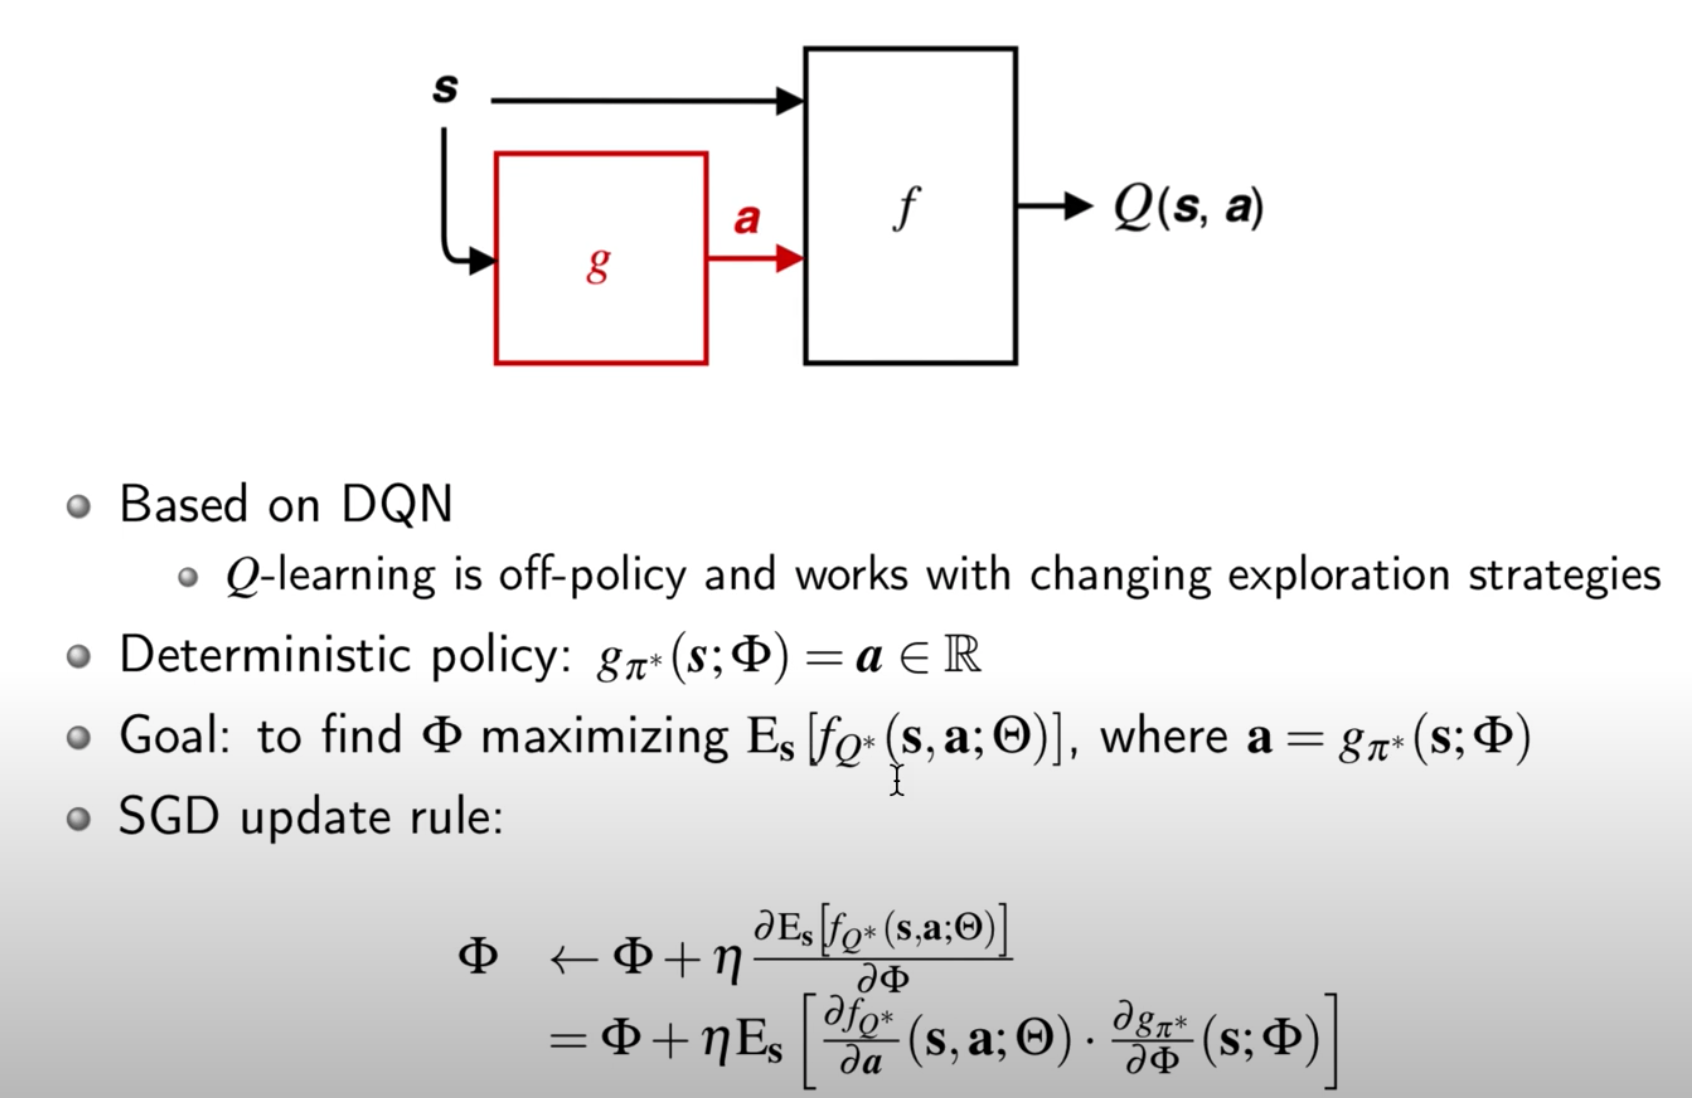
[Source](https://www.youtube.com/watch?v=E9vH6WD_eSE)

Here we have two neural networks to represent action value $Q(s,a)$ and deterministic policy $ a = g_{\pi^*}(s;\Phi)$, respectively:

- neural network $f_{Q^*}(s,a;\Theta)$ map state $s$ and action $a$ to action value $Q^*(s,a)$, with $\Theta$ as its network parameters (the 'wiring of deep learning brain'). This is the `critic` part which measure the value of the $(s,a)$ pairs.

- neural network $g_{\pi^*}(s;\Phi)$ map state $s$ to action $a$, with $\Phi$ as its network parameters. This is the `actor` part which tells the agent what action to take for every observation $s$.


### 2. DDPG uses experience replay

Similar to DQN, in order to train a deep neural network to approximate $Q^*(s,a)$ we use an experience replay buffer. When we feed the experience tuples $(s,a,r,s')$ sequentially to train the neural network, there exists a correlationship between two consecutive tuples. To avoid this, we store experience tuples in a replay buffer and randomly sample a batch to calculate the expected value function.

### 3. DDPG uses local-target networks to stablize learning

Q-learning algorithms make use of **target networks**. The term

> $r + \gamma \max_{a'} Q_{\Phi}(s',a') \approx r + \gamma f_{Q^*}(s',g_{\pi^*}(s; \Phi);\Theta) $

is called the **target**, because when we minimize the Mean Squared Bellman Error (MSBE) loss, we are trying to make the Q-function be more like this target. However, the problem is, the target depends on the same parameters we are trying to train: $\Theta$. This makes MSBE minimization unstable. The solution is to use a set of parameters which comes close to $\Theta$, but with a time delay—that is to say, a second network, called the **target network** (with parameters $\Theta^{-}$) , which lags the first, called the **local network**, with parameters $\Theta$.

In DQN-based algorithms, the target network is just copied over from the main network every some-fixed-number of steps. In contrast, DDPG adopts a `soft update process`: the target network is updated once per main network update by weighted averaging:

> $\Theta^{-} \leftarrow \tau \Theta^{-} + (1 - \tau) \Theta$,

where $\tau$ is a hyperparameter within $[0,1]$ and usually close to 1.

### 4. DDPG use OU or other noise process to achieve 'Exploration vs. Exploitation'
DDPG trains a deterministic policy $a = g(s; \Phi)$ in an off-policy way. Because the policy is deterministic, if the agent were to explore on-policy, in the beginning it would probably not try a wide enough variety of actions to find useful learning signals. To make DDPG policies explore better, we add noise to their actions at training time. $a = g(s; \Phi) + z$, where $z$ is either time-correlated OU noise, or uncorrelated, mean-zero Gaussian noise.

### Summary
Putting all the above techniques together, we have DDPG algorithm as following:

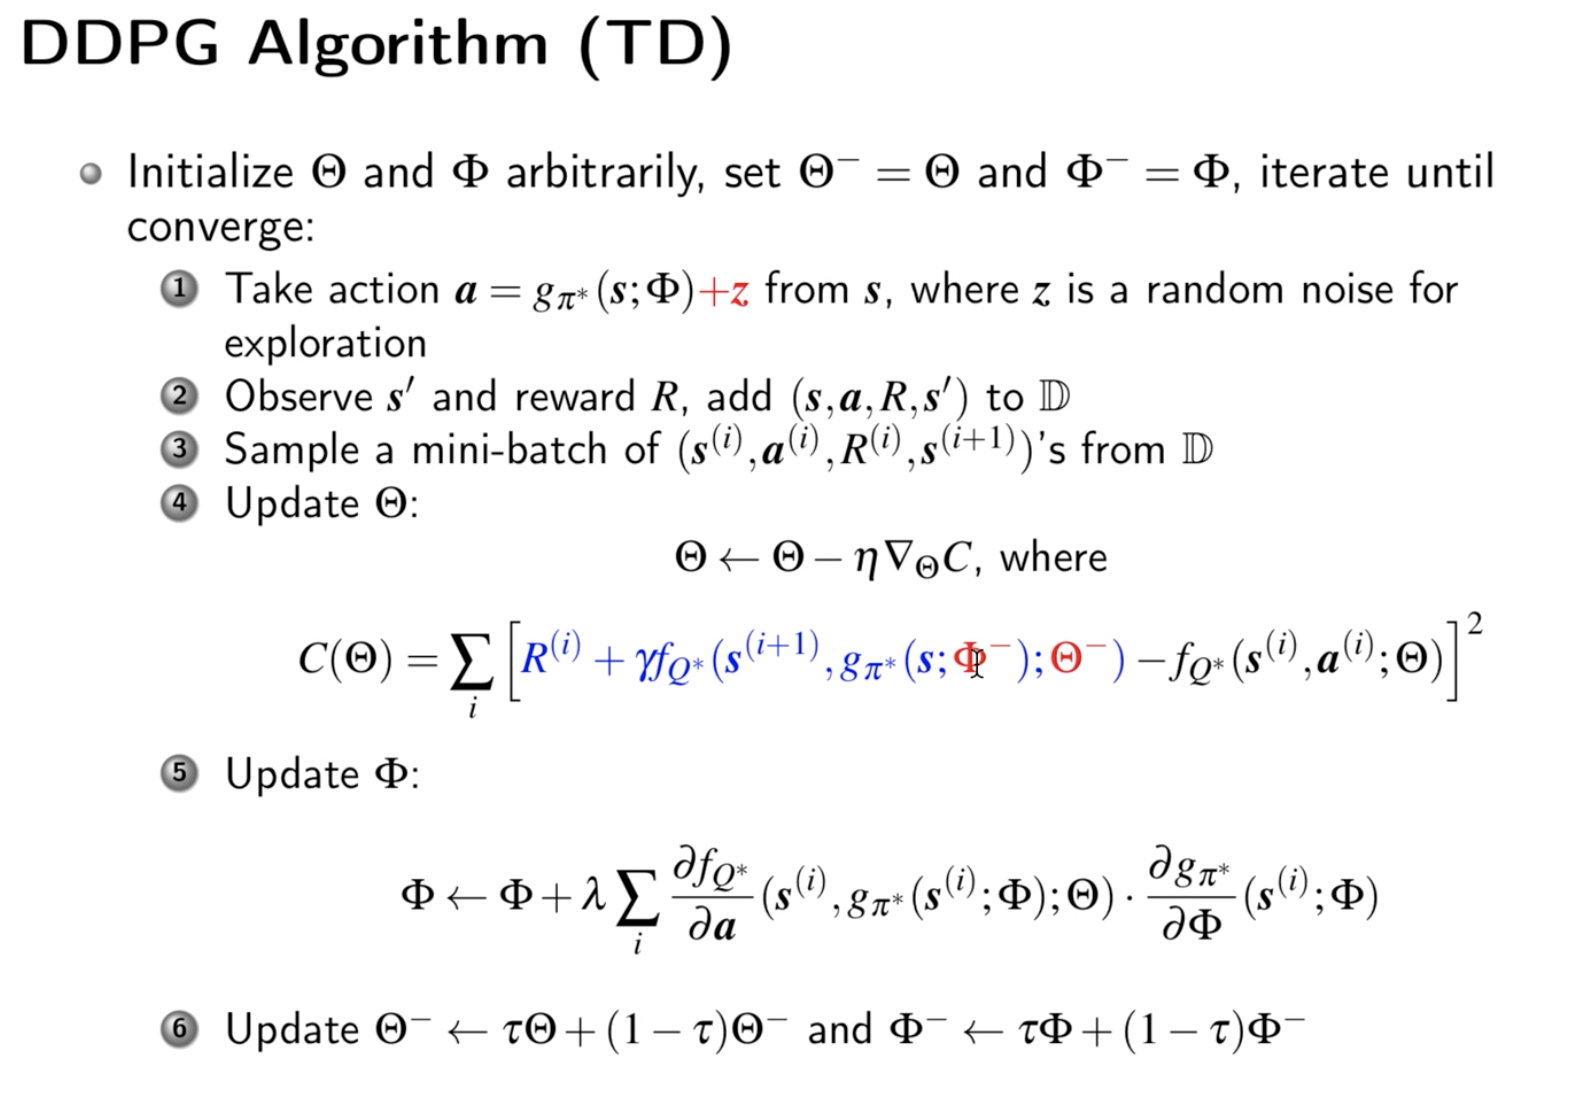
[Source](https://www.youtube.com/watch?v=E9vH6WD_eSE)


### DDPG hyperparameters

For ddpg_agent:
- Replay buffer size: 1e6
- batch size: 1024
- Discount factor (gamma): 0.99                      
- Soft update parameter (tau): 1e-3                     
- Learning rate of Actorlr_actor: 1e-4                 
- Learning rate of Criticlr_critic:1e-3                 
- L2 weight decay: 0.0001 
- Number of parallel agents 20   
- Frquency of updating actor and critic networks: after every 20 time steps
- Frequency of updating the networks when ready to: 10 

For ddpg_model:


## Results
Environment is solved in 273 Episodes with Average Score: 30.03.

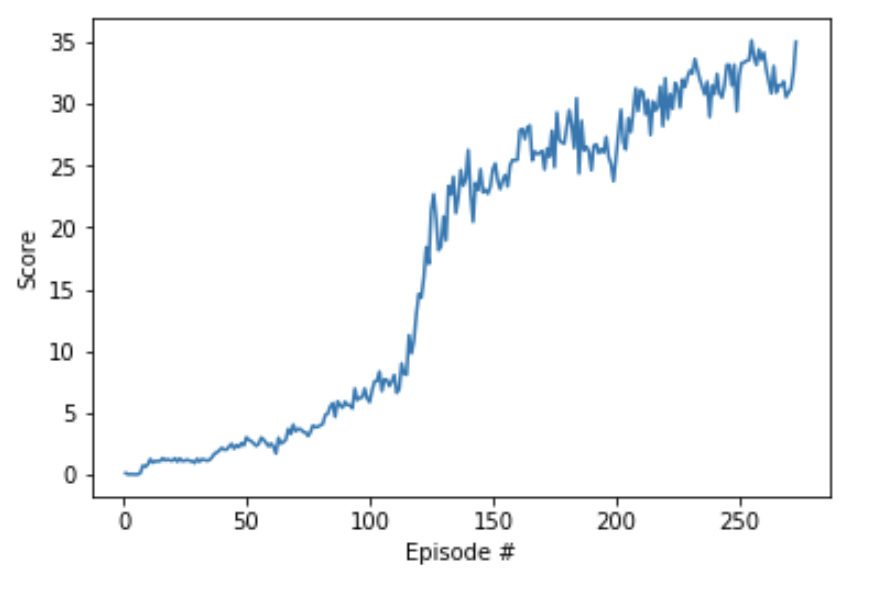

## Next Steps

The performance of the DDPG agent is quite sensitive to its hyperparameters. A systematic way to screen hyperparameters is needed. 

There need to be a better way to visualize how well the networks learn the signal. However, tools such as tensorboard is limited to tensorflow and yet to be available to pytorch. I would like to implement a tensorflow version to utilize the tensorboard tool.

It also takes a long time to run one episode using my local machine. I would explore how to run the training through google colab which provides more computational power for free.

As suggested by Udacity, it's worth to try algorithms such as PPO, A3C, and D4PG that use multiple (non-interacting, parallel) copies of the same agent to distribute the task of gathering experience. I tried to use package [Stable Baselines](https://stable-baselines.readthedocs.io/en/master/) which requires a gym like environment. [gym_unity](https://github.com/Unity-Technologies/ml-agents/tree/master/gym-unity) package could be used to convert the unity environment into a gyn one, however, it's limited to environment with a single Agent. It need to work out the extension version of gym_unity which can use environment with multiple agents.